# YouTube popularity predictor (Part 4): the vector embedding approach

In the [previous notebook](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/eval.ipynb) we used TF-IDF vectorisation in combination with classical ML methods to predict the popularity of YouTube videos using their text metadata. In the next two notebooks we will explore complementary approaches based on pre-trained large-language models. In this notebook I will borrow a technique used in transformer models -- *vector embeddings* -- to convert the text metadata into a single numerical feature, an *embedding vector*, and then proceed with classical ML methods to perform classification. The embedding vector represents the conversion of a sample of text into a high-dimensional co-ordinate vector in which the distance between vectors represents the degree of semantic similarity between the texts.

While this is a more advanced natural language processing method than the text-frequency based method we looke at previously, it leads to a smaller dimensional feature space: a TF-IDF vector has millions of dimensions, each corresponding to the count of a token or n-gram, while the embedding vectors produced by the model we will look at now has a dimension of 1536. Because the embedding vector does not represent a frequency, its co-ordinate entries can be of arbitrary sign, and for this reason, we will not be using multinomial naive Bayes, which was one of the most successful models that appeared in our TF-IDF analysis. We will be using regression models -- gradient-boosed support vector machines, logistic regression, and the perceptron algorithm -- as we did previously. We will also use a gradient-boosted decision tree algorithm, implemented in the CatBoost library, that was not suitable for TF-IDF due to the large feature space.

## Preparing the training data

Let's import the training data and the transformer model that we will use for vectorisation.

In [ ]:
#pip install -U sentence-transformers

In [ ]:
#pip install optuna

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc='processing rows')
pd.options.display.float_format = '{:.6e}'.format

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/youtube_predictor/data/train.csv', lineterminator='\n')
train

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,BKTVOK,22,BAWAR KHAN SON MUHAMMAD Khan Short video YouT...,Bawarkhan SON MUHAMMAD khan \nAmazing Videos\n...,19,1.982271e+00,0
1,Rockit14,20,Add realistic waves to Minecraft! (Physics Mod),Play Minecraft with realistic physics! This mi...,11,5.338389e+00,1
2,MAD ABOUT SCIENCE,22,The Stirling Engine at my Institute,Very close to Carnot Engine\n\n This one is...,50,5.685385e+00,1
3,BKTVOK,22,Shergarh Bazar video YouTube amazing viralvide...,Shergarh Bazar video YouTube amazing viralvide...,21,2.287802e+00,0
4,HVTraining,17,Cycling Tips: The science of electrolytes and ...,Looking for a proven training plan? \nhttps://...,72,3.307282e+00,0
...,...,...,...,...,...,...,...
25323,Khanish,22,Friction welding #tools #science #viral,Friction welding is a solid-state welding proc...,57,3.766115e+00,0
25324,TungaloyCorporation,28,We made a smile with high feed machining! #cn...,Product : AddDoFeed\nShank : VSSD08L090S05-C\n...,2,5.627098e+00,1
25325,Sansad TV,25,Science Monitor | 14.08.2021,1.HUMAN-BASED MODELS TO STUDY NEURODEVELOPMENT...,32,4.421341e+00,0
25326,The Truth Show,27,Trick for Reactivity Series of Metals #shorts ...,Join our Telegram Group ATP STAR JEE/NEET 2024...,18,6.748217e+00,1


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_transformer_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

We will replace NA values in the data with empty strings, and convert the video category into text, then perform the embeddings of the video category, channel title, video title and video descriptions.

In [ ]:
train = train.fillna('')

In [ ]:
video_categories = {1: 'Film & Animation',
                    2: 'Autos & Vehicles',
                    10: 'Music',
                    15: 'Pets & Animals',
                    17: 'Sports',
                    19: 'Travel & Events',
                    20: 'Gaming',
                    22: 'People & Blogs',
                    23: 'Comedy',
                    24: 'Entertainment',
                    25: 'News & Politics',
                    26: 'Howto & Style',
                    27: 'Education',
                    28: 'Science & Technology',
                    29: 'Nonprofits & Activism',
                    30: 'Movies'}

train['video_category'] = train['video_category'].apply(lambda category: video_categories[category])

In [ ]:
train['video_category_embedding'] = train['video_category'].progress_apply(sentence_transformer_model.encode)
train['video_category_embedding']

processing rows: 100%|██████████| 25328/25328 [03:00<00:00, 140.49it/s]


0        [-0.047742732, -0.05303685, -0.015443143, 0.01...
1        [0.039516002, 0.00193585, 0.0035856115, -0.063...
2        [-0.047742732, -0.05303685, -0.015443143, 0.01...
3        [-0.047742732, -0.05303685, -0.015443143, 0.01...
4        [0.0012439805, 0.07559643, -0.017228445, -0.02...
                               ...                        
25323    [-0.047742732, -0.05303685, -0.015443143, 0.01...
25324    [-0.01142108, 0.025579736, -0.004072155, 0.025...
25325    [0.044936396, -0.022796795, -0.013646873, 0.07...
25326    [0.030874368, 0.09993654, -0.020642998, 0.0769...
25327    [0.030874368, 0.09993654, -0.020642998, 0.0769...
Name: video_category_embedding, Length: 25328, dtype: object

In [ ]:
train['channel_title_embedding'] = train['channel_title'].progress_apply(sentence_transformer_model.encode)
train['channel_title_embedding']

processing rows: 100%|██████████| 25328/25328 [03:11<00:00, 132.17it/s]


0        [-0.09609845, 0.043370157, -0.0807076, -0.0111...
1        [-0.087247334, 0.07544038, -0.008406499, -0.08...
2        [-0.011535939, -0.0005409775, 0.0567983, 0.072...
3        [-0.09609845, 0.043370157, -0.0807076, -0.0111...
4        [-0.037332788, 0.027855331, -0.0084582465, -0....
                               ...                        
25323    [-0.05469675, 0.036359876, 0.060655754, 0.0499...
25324    [-0.067716315, 0.0039422796, -0.03660963, 0.05...
25325    [0.023609491, -0.023912432, -0.015329523, -0.0...
25326    [-0.0804492, -0.0047984477, -0.043139737, 0.07...
25327    [0.06331089, -0.006918716, -0.011255805, 0.033...
Name: channel_title_embedding, Length: 25328, dtype: object

In [ ]:
train['video_title_embedding'] = train['video_title'].progress_apply(sentence_transformer_model.encode)
train['video_title_embedding']

processing rows: 100%|██████████| 25328/25328 [03:55<00:00, 107.62it/s]


0        [-0.10120553, 0.078263, -0.006624734, -0.05465...
1        [-0.0751717, 0.0034419817, 0.032594364, 0.0049...
2        [-0.16473493, -0.0042304574, -0.005567808, 0.0...
3        [-0.09340919, 0.005268602, -0.050282124, -0.07...
4        [0.021639146, 0.031574592, 0.006119422, 0.0239...
                               ...                        
25323    [-0.0804554, -0.010029516, 0.033991832, 0.0278...
25324    [-0.12310685, -0.004851357, 0.018700115, -0.00...
25325    [-0.05418567, -0.009164412, 0.027128765, 0.073...
25326    [-0.1949715, 0.037706215, -0.008022115, 0.0620...
25327    [-0.00476516, 0.01971681, -0.0036625315, -0.08...
Name: video_title_embedding, Length: 25328, dtype: object

In [ ]:
train['video_description_embedding'] = train['video_description'].progress_apply(sentence_transformer_model.encode)
train['video_description_embedding']

processing rows: 100%|██████████| 25328/25328 [10:31<00:00, 40.13it/s]


0        [-0.069871925, 0.08336206, -0.011590457, -0.09...
1        [-0.09592351, -0.03006202, 0.06075715, 0.01207...
2        [-0.12476303, 0.021107119, -0.058932617, 0.042...
3        [-0.03792895, 0.01508941, -0.014284179, -0.055...
4        [-0.03985485, 0.025484713, -0.051799506, 0.029...
                               ...                        
25323    [-0.085560635, -0.010037311, 0.011259326, 0.06...
25324    [-0.069452815, 0.012206934, -0.0694892, 0.0315...
25325    [0.031518694, -0.034793533, 0.036886696, 0.019...
25326    [-0.12587897, 0.058197003, 0.09507117, -0.0900...
25327    [-0.1188384, 0.048298717, -0.0025480962, -0.01...
Name: video_description_embedding, Length: 25328, dtype: object

In [ ]:
train.to_csv('train_embedded.csv', index=False, sep=',', encoding='utf-8')

We are now ready to combine the four features into a single vector.

In [ ]:
X_train = np.block([np.array(train['video_category_embedding'].tolist()),
                    np.array(train['channel_title_embedding'].tolist()),
                    np.array(train['video_title_embedding'].tolist()),
                    np.array(train['video_description_embedding'].tolist())])
y_train = train['label']

In [ ]:
X_train.shape

(25328, 1536)

Let's look at the distribution of values in the training data:

Text(0.5, 1.0, 'Distribution of values in X_train')

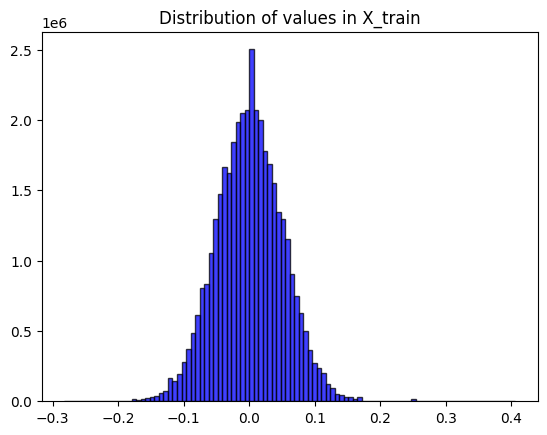

In [ ]:
import matplotlib.pyplot as plt

plt.hist(X_train.flatten(), bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.title("Distribution of values in X_train")

We see a roughly gaussian distribution of vector components centred at zero. The components occupy a total range of less than 1 so we will not need to normalise the features.

## Hyperparemter optimisation

We are now ready to train our linear models as before, using statistical regularisation to avoid overfitting, as the feature space is large. We will use elasticnet regularisation. Let's import the optuna library, which we will use to optimise the L1 and L2 penalty terms with five-fold cross-validation, and build the cross-validation pipeline.

In [ ]:
from sklearn.model_selection import cross_validate, KFold
import optuna

max_trials=100

def objective(trial, X_train, y_train, estimator, get_params, scoring):
    np.random.seed(524)
    params = get_params(trial=trial)
    model = estimator(**params)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=KFold(n_splits=5, random_state=524, shuffle=True), n_jobs=-1, verbose=0)
    return np.mean(scores['test_score'])

def report_optuna_results(X_train, y_train, estimator, get_params, scoring):
    sampler = optuna.samplers.TPESampler(seed=524)
    study = optuna.create_study(sampler=sampler, direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, estimator, get_params, scoring), n_trials=max_trials)
    return study.best_params

def report_tuned_model(X_train, y_train, estimator, get_params, scoring_tune, scoring_report):
    best = report_optuna_results(X_train, y_train, estimator, get_params, scoring_tune)
    model = estimator(**get_params(best=best))
    scores = cross_validate(model, X_train, y_train, scoring=scoring_report, cv=KFold(n_splits=5, random_state=524, shuffle=True), n_jobs=-1, verbose=5)

    cv_results = {}
    cv_results['mean_fit_time'] = np.mean(scores['fit_time'])
    for score in scoring_report:
        cv_results[score] = f'{np.min(scores["test_"+score]):.5f}/{np.mean(scores["test_"+score]):.5f}/{np.max(scores["test_"+score]):.5f}'
    for param in best:
        cv_results[param] = best[param]
    return cv_results

In [ ]:
from sklearn.linear_model import SGDClassifier

We can now perform cross-validation to obtain the optimal L1 and L2 penalty coefficients.

### Support Vector Machine


In [ ]:
%%time

def get_params_SVM(trial=None, best=None):
    if trial != None:
        alpha = trial.suggest_float('alpha', 1e-9, 1e+1, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elif best != None:
        alpha = best['alpha']
        l1_ratio = best['l1_ratio']
    return {'random_state': 524, 'n_jobs': -1, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': alpha, 'l1_ratio': l1_ratio}

SVM_tune = report_tuned_model(X_train, y_train, SGDClassifier, get_params_SVM, 'accuracy', ('accuracy', 'precision', 'recall', 'f1'))

[I 2024-07-19 04:22:04,601] A new study created in memory with name: no-name-e4d1199e-4adb-49d2-943c-ae64026e5f77
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[I 2024-07-19 04:22:10,398] Trial 0 finished with value: 0.7144266111805899 and parameters: {'alpha': 0.0015376911652393395, 'l1_ratio': 0.3925870682115522}. Best is trial 0 with value: 0.7144266111805899.
[I 2024-07-19 04:23:01,110] Trial 1 finished with value: 0.6690239597432353 and parameters: {'alpha': 6.795850794294448e-08, 'l1_ratio': 0.9099172847632808}. Best is trial 0 with value: 0.7144266111805899.
[I 2024-07-19 04:23:06,163] Trial 2 finished with value: 0.7362997027587278 and parameters: {'alpha': 0.00040691375225885087, 'l1_ratio': 0.559987589925726}. Best is trial 2 with value: 0.7362997027587278.
[I 2024-

CPU times: user 11.3 s, sys: 6.65 s, total: 18 s
Wall time: 20min 15s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


In [ ]:
SVM_tune

{'mean_fit_time': 8.645646047592162,
 'accuracy': '0.73964/0.74609/0.75128',
 'precision': '0.68780/0.71707/0.74367',
 'recall': '0.52602/0.59079/0.64646',
 'f1': '0.60988/0.64655/0.66649',
 'alpha': 3.802731498418212e-05,
 'l1_ratio': 0.5305367239722639}

### Logistic regression

In [ ]:
%%time

def get_params_log_reg(trial=None, best=None):
    if trial != None:
        alpha = trial.suggest_float('alpha', 1e-9, 1e+1, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elif best != None:
        alpha = best['alpha']
        l1_ratio = best['l1_ratio']
    return {'random_state': 524, 'n_jobs': -1, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': alpha, 'l1_ratio': l1_ratio}

log_reg_tune = report_tuned_model(X_train, y_train, SGDClassifier, get_params_log_reg, 'accuracy', ('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

[I 2024-07-19 04:42:20,605] A new study created in memory with name: no-name-e94587e2-3de3-4203-b637-67c0c2845bb5
[I 2024-07-19 04:42:24,136] Trial 0 finished with value: 0.6899081930949765 and parameters: {'alpha': 0.0015376911652393395, 'l1_ratio': 0.3925870682115522}. Best is trial 0 with value: 0.6899081930949765.
[I 2024-07-19 04:43:24,418] Trial 1 finished with value: 0.6752585204033315 and parameters: {'alpha': 6.795850794294448e-08, 'l1_ratio': 0.9099172847632808}. Best is trial 0 with value: 0.6899081930949765.
[I 2024-07-19 04:43:28,695] Trial 2 finished with value: 0.7242575768854088 and parameters: {'alpha': 0.00040691375225885087, 'l1_ratio': 0.559987589925726}. Best is trial 2 with value: 0.7242575768854088.
[I 2024-07-19 04:43:37,004] Trial 3 finished with value: 0.739260743379883 and parameters: {'alpha': 2.6074972019493715e-05, 'l1_ratio': 0.6961134464846077}. Best is trial 3 with value: 0.739260743379883.
[I 2024-07-19 04:43:39,849] Trial 4 finished with value: 0.6054

CPU times: user 13 s, sys: 6.24 s, total: 19.2 s
Wall time: 25min 5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


### Perceptron

In [ ]:
%%time

def get_params_perceptron(trial=None, best=None):
    if trial != None:
        alpha = trial.suggest_float('alpha', 1e-9, 1e+1, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    elif best != None:
        alpha = best['alpha']
        l1_ratio = best['l1_ratio']
    return {'random_state': 524, 'n_jobs': -1, 'loss': 'perceptron', 'penalty': 'elasticnet', 'alpha': alpha, 'l1_ratio': l1_ratio}

perceptron_tune = report_tuned_model(X_train, y_train, SGDClassifier, get_params_perceptron, 'accuracy', ('accuracy', 'precision', 'recall', 'f1'))

[I 2024-07-19 05:07:25,818] A new study created in memory with name: no-name-8339e070-7887-4066-9236-28e7077ad262
[I 2024-07-19 05:07:27,876] Trial 0 finished with value: 0.6318690111846431 and parameters: {'alpha': 0.0015376911652393395, 'l1_ratio': 0.3925870682115522}. Best is trial 0 with value: 0.6318690111846431.
[I 2024-07-19 05:08:13,660] Trial 1 finished with value: 0.6624258426480234 and parameters: {'alpha': 6.795850794294448e-08, 'l1_ratio': 0.9099172847632808}. Best is trial 1 with value: 0.6624258426480234.
[I 2024-07-19 05:08:16,272] Trial 2 finished with value: 0.6019855264896262 and parameters: {'alpha': 0.00040691375225885087, 'l1_ratio': 0.559987589925726}. Best is trial 1 with value: 0.6624258426480234.
[I 2024-07-19 05:08:24,488] Trial 3 finished with value: 0.6587188265926298 and parameters: {'alpha': 2.6074972019493715e-05, 'l1_ratio': 0.6961134464846077}. Best is trial 1 with value: 0.6624258426480234.
[I 2024-07-19 05:08:26,418] Trial 4 finished with value: 0.57

CPU times: user 24.9 s, sys: 8.77 s, total: 33.6 s
Wall time: 53min 19s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


In [ ]:
pd.DataFrame([SVM_tune, log_reg_tune, perceptron_tune])

,mean_fit_time,accuracy,precision,recall,f1,alpha,l1_ratio,roc_auc
0,8.645646e+00,0.73964/0.74609/0.75128,0.68780/0.71707/0.74367,0.52602/0.59079/0.64646,0.60988/0.64655/0.66649,3.802731e-05,5.305367e-01,NaN
1,9.571222e+00,0.73648/0.74396/0.74965,0.67351/0.69397/0.72494,0.58939/0.62998/0.67906,0.64475/0.65965/0.67889,1.411708e-05,9.126235e-01,0.80498/0.81004/0.81670
2,1.864987e+01,0.67292/0.69583/0.71175,0.56479/0.63629/0.70105,0.45238/0.58349/0.75287,0.54991/0.59729/0.64541,2.199799e-09,2.491807e-01,NaN


We see that the optimised cross-validation scores are significantly lower than we found for TF-IDF.

## CatBoost

CatBoost is a popular library for gradient boosting on decision trees and a worthwhile candidate model to use with feature spaces of the dimensions we are currently considering. Its algorithm is iterative, and there are two important hyperparameters: the learning rate, which controls the degree of incremental change in the model from one iteration to the next, and the number of iterations. We will choose a learning rate that is small enough to allow us to stop training when overfitting is observed but large enough that it converges to a minimum of the loss function. We will use a single training/validation split.

Let's import the library, form the validation set and train the model. We will use early stopping so that training ceases when the loss function no longer improves on the validation set.

In [ ]:
#pip install catboost

In [ ]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(iterations=100000, learning_rate=1e-1, od_type="Iter", od_wait=100)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_catboost, X_val, y_train_catboost, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=524)
catboost_clf.fit(X_train_catboost, y_train_catboost, eval_set=(X_val, y_val))

0:	learn: 0.6778785	test: 0.6782826	best: 0.6782826 (0)	total: 106ms	remaining: 2h 57m 2s
1:	learn: 0.6647461	test: 0.6658401	best: 0.6658401 (1)	total: 175ms	remaining: 2h 26m 10s
2:	learn: 0.6528143	test: 0.6548600	best: 0.6548600 (2)	total: 247ms	remaining: 2h 17m 10s
3:	learn: 0.6440531	test: 0.6466986	best: 0.6466986 (3)	total: 317ms	remaining: 2h 12m 11s
4:	learn: 0.6370019	test: 0.6408173	best: 0.6408173 (4)	total: 385ms	remaining: 2h 8m 25s
5:	learn: 0.6302074	test: 0.6341246	best: 0.6341246 (5)	total: 456ms	remaining: 2h 6m 44s
6:	learn: 0.6238576	test: 0.6281439	best: 0.6281439 (6)	total: 527ms	remaining: 2h 5m 29s
7:	learn: 0.6175587	test: 0.6223550	best: 0.6223550 (7)	total: 596ms	remaining: 2h 4m 10s
8:	learn: 0.6123801	test: 0.6179920	best: 0.6179920 (8)	total: 664ms	remaining: 2h 2m 56s
9:	learn: 0.6079022	test: 0.6139955	best: 0.6139955 (9)	total: 734ms	remaining: 2h 2m 17s
10:	learn: 0.6036102	test: 0.6102967	best: 0.6102967 (10)	total: 803ms	remaining: 2h 1m 38s
11:	l

We see that we obtained an optimal loss after 900 iterations with a validation loss of 0.432 and a training loss of 0.106. These values are the binary cross-entropy, but we can also look at the classification metrics (accuracy, precision, recall, F1).

In [ ]:
from sklearn.metrics import *

y_pred = catboost_clf.predict(X_val)
metrics = {'accuracy': accuracy_score(y_val, y_pred),
           'precision': precision_score(y_val, y_pred),
           'recall': recall_score(y_val, y_pred),
           'f1': f1_score(y_val,y_pred)}

for key in metrics:
    print(f"{key}: {metrics[key]}")

accuracy: 0.792735886300829
precision: 0.769971671388102
recall: 0.6784822765851223
f1: 0.7213375796178344


The observed validation accuracy of 0.793 is similar to what we found for the TF-IDF models and significantly better than the linear models we looked at earlier in this notebook.

By default, CatBoost employs L2 regularisation, associated with a parameter l2_leaf_reg, with a default value of 3.0. Let's see if we can improve the performance of the model by tuning this parameter. We will vary this parameter within the range [10$^{-9}$, 10$^1$].

In [ ]:
%%time

catboost_val_scores = []

print("l2_leaf_reg\tval. accuracy\ttree count")

for l2_leaf_reg in np.logspace(-9, 1, 10):
    clf = CatBoostClassifier(iterations=100000, learning_rate=1e-1, od_type="Iter", od_wait=100,
            verbose=False, l2_leaf_reg = l2_leaf_reg, random_state=524)
    clf.fit(X_train_catboost, y_train_catboost, eval_set=(X_val, y_val))
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    catboost_val_scores.append({'l2_leaf_reg': l2_leaf_reg, 'accuracy': acc, 'tree_count': clf.tree_count_})
    print(f"{l2_leaf_reg:.6e}\t{acc:.6e}\t{clf.tree_count_}")

l2_leaf_reg	val. accuracy	tree count
1.000000e-09	7.737860e-01	317
1.291550e-08	7.698381e-01	321
1.668101e-07	7.779313e-01	361
2.154435e-06	7.716147e-01	259
2.782559e-05	7.741808e-01	343
3.593814e-04	7.844453e-01	366
4.641589e-03	7.933281e-01	614
5.994843e-02	7.820766e-01	512
7.742637e-01	7.887880e-01	881
1.000000e+01	8.018160e-01	1124
CPU times: user 52min 17s, sys: 40.9 s, total: 52min 58s
Wall time: 7min 20s


We see that the validation accuracy rises to its highest value at the end of the range. Let's continue to increase the L2 coefficient further:

In [ ]:
for l2_leaf_reg in np.logspace(1, 3, 10):
    clf = CatBoostClassifier(iterations=100000, learning_rate=1e-1, od_type="Iter", od_wait=100,
            verbose=False, l2_leaf_reg = l2_leaf_reg, random_state=524)
    clf.fit(X_train_catboost, y_train_catboost, eval_set=(X_val, y_val))
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    catboost_val_scores.append({'l2_leaf_reg': l2_leaf_reg, 'accuracy': acc, 'tree_count': clf.tree_count_})
    print(f"{l2_leaf_reg:.6e}\t{acc:.6e}\t{clf.tree_count_}")

1.000000e+01	8.018160e-01	1124
1.668101e+01	7.951046e-01	1194
2.782559e+01	7.990525e-01	1137
4.641589e+01	7.986577e-01	1251
7.742637e+01	7.992499e-01	1227
1.291550e+02	8.028030e-01	1527
2.154435e+02	8.030004e-01	1582
3.593814e+02	7.982629e-01	2327
5.994843e+02	7.980655e-01	2840
1.000000e+03	8.014212e-01	4151


The validation loss plateaus as the coefficient is varied by 2 orders of magnitude between 10 and 1000. We can visualise this with a plot.

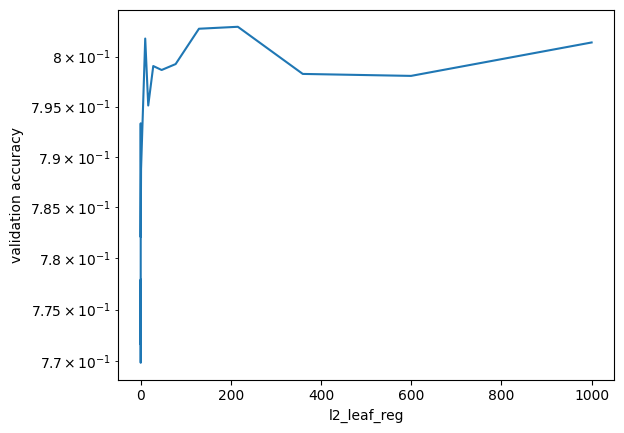

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel("l2_leaf_reg")
ax.set_ylabel("validation accuracy")
ax.set_yscale('log')
ax.plot([score['l2_leaf_reg'] for score in catboost_val_scores], [score['accuracy'] for score in catboost_val_scores])

We can now train a final model using the entire training set using the value of l2_leaf_reg = 10, which was where the validation accuracy plateaued, and the same number of iterations.

In [ ]:
clf_final = CatBoostClassifier(iterations=1089, learning_rate=1e-1, verbose=False, l2_leaf_reg = 10, random_state=524)
clf_final.fit(X_train, y_train)

Since the validation accuracy is similar to our TF-IDF models, we can go further and evaluate the CatBoost model on our test data. Let's import the test set and prepare the features for the model as we did earlier for the training set.

In [ ]:
test = pd.read_csv('https://raw.githubusercontent.com/tommyliphysics/tommyli-ml/main/youtube_predictor/data/test.csv', lineterminator='\n')
test

,channel_title,video_category,video_title,video_description,months,video_view_count,label
0,RG LECTURES,27,MHTCET FULL REVISION ONE SHOT ALL FORMULAS - P...,MHTCET PHYSICS FULL COMPLETE ONE SHOT REVISION...,11,5.238984e+00,1
1,FuTechs,28,Tony Robbin and Robot conversation Relationshi...,"Speaker :Anthony Jay Robbins (né Mahavoric, bo...",10,4.364063e+00,0
2,That Chemist,27,Nobel Prize in Chemistry 2022 (Recap),The Nobel Prize in Chemistry for 2022 has been...,18,4.484656e+00,0
3,SCIENCE FUN For Everyone!,27,Friction Fun Friction Science Experiment,Have fun exploring friction with this easy sci...,36,4.503437e+00,0
4,Michigan Medicine,26,Deconstructing the Legitimization of Acupunctu...,"Rick Harris, PhD\nAssociate Professor, Anesthe...",57,4.632467e+00,0
...,...,...,...,...,...,...,...
6328,CARB ACADEMY,27,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,Class 8th Maths Chapter 1 l NCERT EXERCISE-1.1...,16,5.496467e+00,1
6329,Rafael Verdonck's World,22,Science World #7 Will Strangelets destroy th...,Will the universe be destroyed by a tiny eleme...,70,3.183270e+00,0
6330,Trik Matematika mesi,27,deret angka matematika #shorts #maths,NaN,19,5.764919e+00,1
6331,edureka!,27,Statistics And Probability Tutorial | Statisti...,🔥 Data Science Certification using R (Use Code...,59,5.561255e+00,1


In [ ]:
test = test.fillna('')

test['video_category'] = test['video_category'].apply(lambda category: video_categories[category])
test['video_category_embedding'] = test['video_category'].progress_apply(sentence_transformer_model.encode)
test['channel_title_embedding'] = test['channel_title'].progress_apply(sentence_transformer_model.encode)
test['video_title_embedding'] = test['video_title'].progress_apply(sentence_transformer_model.encode)
test['video_description_embedding'] = test['video_description'].progress_apply(sentence_transformer_model.encode)


processing rows: 100%|██████████| 6333/6333 [03:24<00:00, 30.94it/s]


In [ ]:
X_test = np.block([np.array(test['video_category_embedding'].tolist()),
                    np.array(test['channel_title_embedding'].tolist()),
                    np.array(test['video_title_embedding'].tolist()),
                    np.array(test['video_description_embedding'].tolist())])
y_test = test['label']

We can now perform inference and obtain the predicted classes and probabilities for the test data.

In [ ]:
y_pred = clf_final.predict(X_test)
y_proba = clf_final.predict_proba(X_test)

Let's look at the confusion matrix and classification metrics.

In [ ]:
cm = confusion_matrix(y_test, y_pred)

metrics = {'accuracy': accuracy_score(y_test, y_pred),
           'precision': precision_score(y_test, y_pred),
           'recall': recall_score(y_test,y_pred),
           'f1': f1_score(y_test,y_pred)}

In [ ]:
display(pd.DataFrame(cm,columns=['predicted under 50k views','predicted over 50k views'],index = ['under 50k views','over 50k views']))

,predicted under 50k views,predicted over 50k views
under 50k views,3385,447
over 50k views,731,1770


In [ ]:
display(pd.DataFrame([metrics]))

,accuracy,precision,recall,f1
0,8.139902e-01,7.983762e-01,7.077169e-01,7.503179e-01


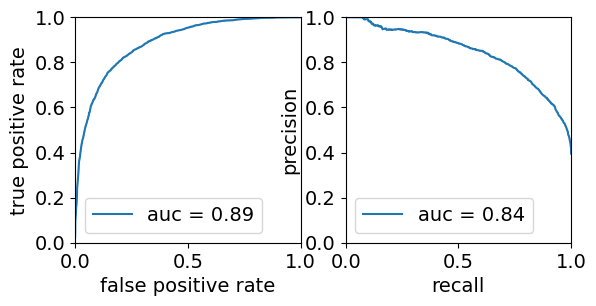

In [ ]:
import seaborn as sns

y_proba = y_proba.T[1]

fig, axes = plt.subplots(1,2)

fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

sns.lineplot(x=fpr, y=tpr, ax = axes[0], label=f'auc = {roc_auc:.2f}')
sns.lineplot(x=recall, y=precision, ax = axes[1], label=f'auc = {pr_auc:.2f}')

axes[0].set_xlabel("false positive rate", fontsize=14)
axes[0].set_ylabel("true positive rate", fontsize=14)
axes[0].set_xlim([0,1])
axes[0].set_ylim([0,1])
axes[0].set_aspect('equal', adjustable='box')
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(fontsize=14)

axes[1].set_xlabel("recall", fontsize=14)
axes[1].set_ylabel("precision", fontsize=14)
axes[1].set_xlim([0,1])
axes[1].set_ylim([0,1])
axes[1].set_aspect('equal', adjustable='box')
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=14)

plt.show()


Our results are very close to what we found for TF-IDF, despite the fact that the approaches were completely different:

1. The use of vector embeddings is a more sophisticated technique than TF-IDF. Here, we used part of a neural network that was pre-trained on a large language corpus, whereas in the TF-IDF notebook we trained all our models from scratch and built a vocabulary from the training data.
2. Using a pre-trained neural network provides us with a way to embed text data into a few-thousand dimensional feature space, whereas TF-IDF allowed us to embed the data into a much larger dimensional space. The vector embedding model has a dimensionality closer to the size of the training set, while the TF-IDF models have a dimensionality orders of magnitude larger.
3. With TF-IDF, we used a naive Bayes classifier, linear models, and stacking. In this notebook, we found similar results using CatBoost.

It appears as if an accuracy in the low 80s is the limit we should expect from the bias-variance tradeoff: there are many features correlated with a video's popularity in addition to the four text fields we have used. Our small selection of video metadata will always result in models with limited predictive power, but with sufficient model complexity, it should be possible to saturate this limit. This may be what is happening here. We have a way to directly provide evidence for or against this hypothesis: in our [final approach](https://github.com/tommyliphysics/tommyli-ml/blob/main/youtube_predictor/notebooks/distilbert.ipynb), we will abandon classical ML methods and use a pre-trained deep learning model to perform classification.